Updated 23 June 2024 by Anna Preus. 

Original:
Devin Short 
30 June 2023 
shortda@uw.edu

<h2>Parsing a partially done catalogue</h2>

This notebook is for exploring how to improve the parsing of partially completed catalogues (ones for which students have already identified some particular regex patterns). 

It requires functions from `reporting.py`, currently living in the scripts directory of the github repository. If you're running this notebook from a directory that doesn't contain `reporting.py` you'll either need to edit the following lines to reflect the relative location of the reporting module or copy `reporting.py` into the current directory.

First, we will import some packages and set the parameters we'll use below. We'll also select the year we're focusing on throughout the rest of the notebook.

In [1]:
import pandas as pd
import re

pd.set_option('display.max_colwidth', 500)

from reporting import histogram_strings_by_length

# Year determines which issue of the catalogue we're looking at across the entire notebook
year = 22

Run the cell below to split the string using existing code: only on entries that end in "22". 

## <u>Implementing Existing Methods</u>

First, we'll read the plain text file into memory, so we can work on chopping it up. The text will initally get pulled in as one long string

In [2]:
# read the Hathi Trust OCR into memory
with open(f'../princeton_years/ecb_19{year}.txt', encoding='utf8') as f:
    ocr_full_text = f.read()

print(ocr_full_text[:1000])

This file was downloaded from HathiTrust Digital Library.
Find more books at https://www.hathitrust.org.

Title:	   The English catalogue of books published from ... to ...

Publisher: London, The Publishers' Circular, Limited

Copyright:
Public Domain in the United States, Google-digitized
http://www.hathitrust.org/access_use#pd-us-google

We have determined this work to be in the public domain in the United
States of America. It may not be in the public domain in other countries.
Copies are provided as a preservation service. Particularly outside of the
United States, persons receiving copies should make appropriate efforts to
determine the copyright status of the work in their country and use the
work accordingly. It is possible that current copyright holders, heirs or
the estate of the authors of individual portions of the work, such as
illustrations or photographs, assert copyrights over these portions.
Depending on the nature of subsequent use that is made, additional rights
may 

Next, we can split off the front matter and back matter by finding the particular textual patterns that precede and follow the list of entries.

In [3]:
# Separate main text from the front matter of the catalogue
# Note python allows multiple assignment: the split operation below creates a 
# two-element list whose elements are then assigned to two different variables
ocr_front_matter, ocr_main_text = re.split(r'\u0410\n', ocr_full_text)

appendix_pattern = (
    r"LEARNED SOCIETIES, PRINTING CLUBS &c., WITH LISTS OF THEIR"
)

# Separate main text from the back matter of the catalogue
ocr_main_text, ocr_back_matter = re.split(appendix_pattern, ocr_main_text)

Now we should have just the list of entries that we want to work with from here on out stored in the variable `ocr_main_text`

In [4]:
print(ocr_main_text[:1000])

A B C guide to the practice of the Supreme
Court, 1923. By F. R. S. Stringer. 18th ed.
71 x 5, pp. 239, 8s. 6d. net.
SWEET & M., Oct. '22
A B C or alphabetical railway guide. (Monthly.)
ea. swd. 28. net. (15, Fetter Lane, E.C.)
OFFICE, Jan., etc., '22
A.D.-Indian child's mother. 35. 6d... Sept. '22
A. E. See E. (A.)
Aaland Islands : Convention respecting non-
fortification and neutralisation, Geneva, Oct.,
1921. 6d. net........ ...H.M.S.O., June '22
Aaron's rod, Lawrence (D. H.) 7s. 6d. net, June '22
Abbé Pierre, Hudson (J. W.) 78. 6d. net. . May'22
Abbeville window, From an, Fedden (M.) 55. net.
Sept. '22
Abbey girls go back to school, Oxenham (E. J.)
6s. net
.Aug. '22
Abbo (St.) of Fleury: Text of " Quaestione
grammaticales,” Bradley (H.) is. net. . Apr.'22
Abbot, Scott (W., Sir) 15. 6d. net ...... Apr. 22
Abbott (G. F.)—Greece and the Allies, 1914–1922.
Cr. 8vo, 74 x 5, pp. 253, 78. 6d. net.
METHUEN, Dec. '22
Abbott_(Jane)-Red-Robin. Illus. by Harriet
R. Richards. 2nd imp. Cr. 8vo, 

Next, we will implement a regular expression that matches headers at the top of each page. Then we will split the text into pages and strip out the headers.

In [5]:
# Make a regular expression to capture headers at the top of each catalogue page
header_capital_letters = r"^(?:[A-Z\-\'\sÈ]+)"
header_pattern = r"^#(?s:.*?){}(?s:.*?){}(?s:.*?){}$".format(
    header_capital_letters, header_capital_letters, header_capital_letters
)

# Split the main text into pages and strip the headers. According to
# Parsing_ECB_1912_wi23.ipynb this method fails to remove six headers.
pages = [
    re.sub(header_pattern, '', page, flags=re.M)
    for page in ocr_main_text.split('\f')
]

Now the body of the text that we're interested in is stored in the variable `pages` as a list of strings, where each string represents a page.

In [6]:
for page in pages[:10]:
    print(page[:1000])

A B C guide to the practice of the Supreme
Court, 1923. By F. R. S. Stringer. 18th ed.
71 x 5, pp. 239, 8s. 6d. net.
SWEET & M., Oct. '22
A B C or alphabetical railway guide. (Monthly.)
ea. swd. 28. net. (15, Fetter Lane, E.C.)
OFFICE, Jan., etc., '22
A.D.-Indian child's mother. 35. 6d... Sept. '22
A. E. See E. (A.)
Aaland Islands : Convention respecting non-
fortification and neutralisation, Geneva, Oct.,
1921. 6d. net........ ...H.M.S.O., June '22
Aaron's rod, Lawrence (D. H.) 7s. 6d. net, June '22
Abbé Pierre, Hudson (J. W.) 78. 6d. net. . May'22
Abbeville window, From an, Fedden (M.) 55. net.
Sept. '22
Abbey girls go back to school, Oxenham (E. J.)
6s. net
.Aug. '22
Abbo (St.) of Fleury: Text of " Quaestione
grammaticales,” Bradley (H.) is. net. . Apr.'22
Abbot, Scott (W., Sir) 15. 6d. net ...... Apr. 22
Abbott (G. F.)—Greece and the Allies, 1914–1922.
Cr. 8vo, 74 x 5, pp. 253, 78. 6d. net.
METHUEN, Dec. '22
Abbott_(Jane)-Red-Robin. Illus. by Harriet
R. Richards. 2nd imp. Cr. 8vo, 

Finally, we split each page up into individual entries using our standard splitting pattern, which currently only splits on the two digit year string. In this case, "22".

In [7]:
# Now find all lines ending in 22 and insert a token to split on
entries_by_page = [
    re.sub(r'(\W22\.?$)', '\\1<ENTRY_CUT>', page, flags=re.M)
    for page in pages
]

# Split on the token to create a list of lists where each element is
# a list of entries on an individual page
entries_by_page = [
    re.split(r'<ENTRY_CUT>', page, flags=re.M)
    for page in entries_by_page
]

print(f'total entries: {sum([len(p) for p in entries_by_page])}')

total entries: 16294


Above, we can see that we have split the text into over 16,000 individual entries, which are stored in the variable `entries_by_page`. We can look at some of the individual entries by writing a nested loop with a print statement. 

In [8]:
for page in entries_by_page[:10]:
    for entry in page:
        print(entry)

A B C guide to the practice of the Supreme
Court, 1923. By F. R. S. Stringer. 18th ed.
71 x 5, pp. 239, 8s. 6d. net.
SWEET & M., Oct. '22

A B C or alphabetical railway guide. (Monthly.)
ea. swd. 28. net. (15, Fetter Lane, E.C.)
OFFICE, Jan., etc., '22

A.D.-Indian child's mother. 35. 6d... Sept. '22

A. E. See E. (A.)
Aaland Islands : Convention respecting non-
fortification and neutralisation, Geneva, Oct.,
1921. 6d. net........ ...H.M.S.O., June '22

Aaron's rod, Lawrence (D. H.) 7s. 6d. net, June '22

Abbé Pierre, Hudson (J. W.) 78. 6d. net. . May'22

Abbeville window, From an, Fedden (M.) 55. net.
Sept. '22

Abbey girls go back to school, Oxenham (E. J.)
6s. net
.Aug. '22

Abbo (St.) of Fleury: Text of " Quaestione
grammaticales,” Bradley (H.) is. net. . Apr.'22

Abbot, Scott (W., Sir) 15. 6d. net ...... Apr. 22

Abbott (G. F.)—Greece and the Allies, 1914–1922.
Cr. 8vo, 74 x 5, pp. 253, 78. 6d. net.
METHUEN, Dec. '22

Abbott_(Jane)-Red-Robin. Illus. by Harriet
R. Richards. 2nd imp

## <u>Testing new methods</u>

Once we have implemented our standard splitting pattern, we can start testing new patterns to improve how we're parsing the entries. First, let's look again at how the entries are broken up at the beginning of the text.

In [9]:
for page in entries_by_page[:20]:
    for entry in page:
        print(entry)
        print("__________________")

A B C guide to the practice of the Supreme
Court, 1923. By F. R. S. Stringer. 18th ed.
71 x 5, pp. 239, 8s. 6d. net.
SWEET & M., Oct. '22
__________________

A B C or alphabetical railway guide. (Monthly.)
ea. swd. 28. net. (15, Fetter Lane, E.C.)
OFFICE, Jan., etc., '22
__________________

A.D.-Indian child's mother. 35. 6d... Sept. '22
__________________

A. E. See E. (A.)
Aaland Islands : Convention respecting non-
fortification and neutralisation, Geneva, Oct.,
1921. 6d. net........ ...H.M.S.O., June '22
__________________

Aaron's rod, Lawrence (D. H.) 7s. 6d. net, June '22
__________________

Abbé Pierre, Hudson (J. W.) 78. 6d. net. . May'22
__________________

Abbeville window, From an, Fedden (M.) 55. net.
Sept. '22
__________________

Abbey girls go back to school, Oxenham (E. J.)
6s. net
.Aug. '22
__________________

Abbo (St.) of Fleury: Text of " Quaestione
grammaticales,” Bradley (H.) is. net. . Apr.'22
__________________

Abbot, Scott (W., Sir) 15. 6d. net ...... Apr. 22


Right now, we have the data saved in a list of lists of strings, where each string is an entry and each sub-list is a page. We can append the list of entries on each page to a new list, so they are stored in a single (rather than nested) list.

In [10]:
initial_entries_list = []

for page in entries_by_page:
    for entry in page:
        initial_entries_list.append(entry)
        
print("Total Entries:")
print(len(initial_entries_list))
print(" ")

for item in initial_entries_list[:30]:
    print(item)
    print("__________________")

Total Entries:
16294
 
A B C guide to the practice of the Supreme
Court, 1923. By F. R. S. Stringer. 18th ed.
71 x 5, pp. 239, 8s. 6d. net.
SWEET & M., Oct. '22
__________________

A B C or alphabetical railway guide. (Monthly.)
ea. swd. 28. net. (15, Fetter Lane, E.C.)
OFFICE, Jan., etc., '22
__________________

A.D.-Indian child's mother. 35. 6d... Sept. '22
__________________

A. E. See E. (A.)
Aaland Islands : Convention respecting non-
fortification and neutralisation, Geneva, Oct.,
1921. 6d. net........ ...H.M.S.O., June '22
__________________

Aaron's rod, Lawrence (D. H.) 7s. 6d. net, June '22
__________________

Abbé Pierre, Hudson (J. W.) 78. 6d. net. . May'22
__________________

Abbeville window, From an, Fedden (M.) 55. net.
Sept. '22
__________________

Abbey girls go back to school, Oxenham (E. J.)
6s. net
.Aug. '22
__________________

Abbo (St.) of Fleury: Text of " Quaestione
grammaticales,” Bradley (H.) is. net. . Apr.'22
__________________

Abbot, Scott (W., Sir) 15. 

We can also store this list of entries as a dataframe and save it as a CSV.

In [11]:
initial_entries_df=pd.DataFrame(initial_entries_list)
initial_entries_df.sample(30)

,0
7242,"\nIndian trail, On the, Young (E. R.) 35. 6d. net.\nAug. '22"
15078,"\nVariety, Grand (S.) 78. 6d. net....... Sept. '22"
5289,"\nFox, George : Founder of Quakerism, Knight\n(R.) 125. 6d. net..\nDec. '22"
7182,"\nIncubation, ABC of, Brown (E. T.) 16s. net\nJan. '22"
6727,"\nHocking (Joseph)—The Ring of destiny. Cheap\ned. 18mo. 64 X 4), pp. 256, 25. net\nWARD, LOCK, June '22"
14560,"\nTheology: a monthly journal of historic Chris-\ntianity. Edit. by E. G. Selwyn. Vol. 4, Jan.\nto June, 1922. 91 x6, pp. 370, 125. 6d. net.\nS.P.C.K., J uly '22."
4567,"\nEnchanted fish, Gaze (H.) 25;, 6d, net.. Feb.'22"
9519,"\n\n\nMilton (Arthur)-Paris in seven days : a guide\nfor people in a hurry. Frontispiece by George\nBelcher, and 4 maps. Cr. 8vo, 71 x 5, pp. 117,\n55. net....\n.MILLS & B., Dec. '22"
10760,"\nPamela herself, Coke (D.) 7s, 6d. net.... Jan. '22"
2490,"\nCensus of Scotland, 1921- Report. Vol.\nPart 7, Ayr, ios. net ; pt. 8, Banff, 6s. net ;\npt. 9, Berwick, 4s. 6d. net. H.M.S.O., Oct. '22"


In [12]:
initial_entries_df.to_csv('initial_entries_1922.csv', index=False, header=False, encoding="utf-8")

And we can look at this data as a histogram to see if we're getting the general lengths we're used to seeing in the entries we've split up so far.

total number of strings: 16294
number of strings shorter than 30 characters: 342, 2.1%
number of strings within outflow limits: 15873
number of strings longer than 300 characters: 79, 0.5%


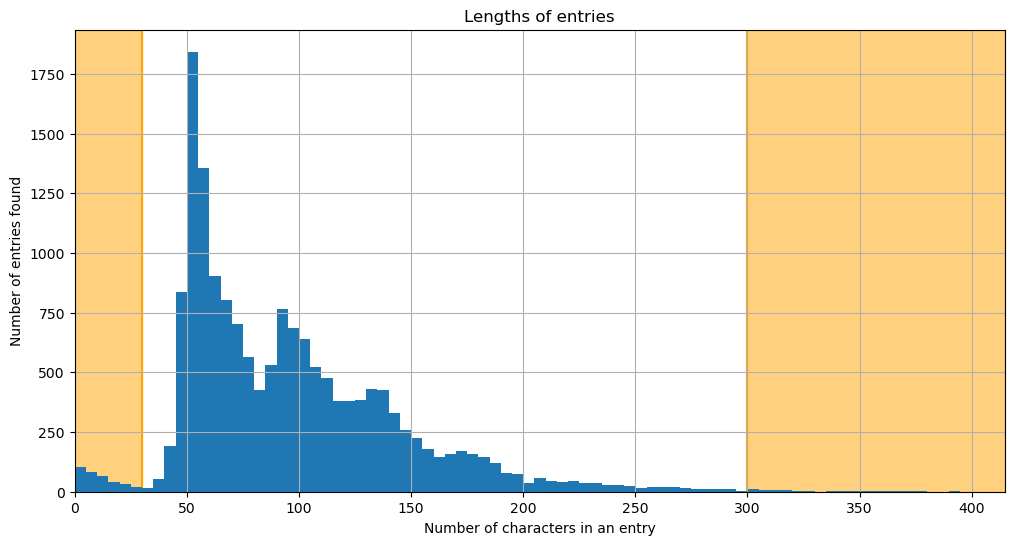

In [13]:
path="initial_entries_1922.csv"

hist_results = histogram_strings_by_length(
    path,
    show_over_under=True,
    drop_nulls=True
)

We can zoom in on the long entries to see where we are potentially splitting incorrectly.

In [19]:
initial_long_entries=[]

for entry in initial_entries_list:
    if len(entry)>300:
        initial_long_entries.append(entry)

long_entries_df = pd.DataFrame(initial_long_entries)

long_entries_df.sample(20)

,0
4,"\nActs of Parliament-Local and private. Aber-\ndeen Corporation order, 25.;\nBlackburn\nCorpn., 55.; Board of Education scheme\n(Dewsbury Endowed Sch.), 6d.; Bristol\nCorpn., ed. net; Buckhaven and Leven gas,\ngd. ; Caledonian Ry, order, is. 3d. ; City of\nLondon (various powers), is. ; Colne Valley\nwater, 3s. ; Dumfries and Maxwelltown water.\nworks, Is.; Girvan water, 25. 3d.; Glasgow\nCorpn. order , 25. 6d.; Glasgow and Rutherglen\nCorpn, order, gd. ; Grangemouth Burgh exten-\nsion, is. ..."
16,"\nBell (C. A.)-English Tibetan colloquial dictionary.\n2nd ed. 8vo. pp. 598, 8s. net .. LUZAC, Dec.'21\nBell (C. A.) Grammar of colloquial Tibetan.\nMap. 2nd ed. 8vo. pp. 234, 6s. net\nLUZAC, Dec. '21\nBell (C. W., Capt.)-The Story of the First Life\nGuards. Cr. 8vo. 77 x 48, pp. 80, 25. 6d. net\nHARRAP, July '22"
14,"\nAsiatic Society (Royal) : Straits Branch\nJournal. No. 84, Malayan fishes, by C. N.\nMaxwell. 72 plates, pp. 103, 75. 6d. net.\nNo. 85, Miscellaneous papers. Illus., PP. 274,\n125. 6d. net. Special number : A Biblio-\ngraphic enumeration of Bornean plants, by\nE, D. Merrill, pp. 637, 3os. net. 8vo. 9£ x 6\nWHELDON & Wesley, June '22"
51,"\nJadhava (K.)–Call to India, England and Empire ;\nor, The Reconstruction of Indian agriculture.\nSvo., pp. 30, 3s. 6d. net ... LUZAC, Dec. '21\nJaggard (Walter R.) and Drury (Francis E.) -\nArchitectural building construction. Vol. 2,\npart 1. 8vo. 9 * 5), pp. 405, 20s. net; also\nVol. 1, 2nd ed., 155. net. (Cambridge technical\nser.)\n.CAMB. UNIV. PR., Nov. '22"
38,"\nFraser (G. M.)—The Old Deeside Road (Aberdeen\nto Braemar): its course, history, and associa-\ntions. 38 illus. and map. 9 XII, pp. 281, 12s. 6d.\nnet..\nABERDEEN UNIV. PR., Dec.'21\nFraser (Hugh, Sir)-Law of Parliamentary\nelections and election petitions. 3rd ed.\nRoy. 8vo, pp. 456, 425. net.\nSWEET & M., Nov. '22"
25,"\nBovy (Daniel Baud-) see Baud-Bovy.\nBowen (Marjorie) -Aftairs of men : accounts\nand impressions of the endeavours of great\nmen, the results of their efforts and their\ndestinies. Illus. by J. Hoynck Van Papen-\ndrecht. Pref. by Lieut.-Gen. F. de Bas.\nCr. 8vo. 74 X 5, pp. 222, 75. 6d. net\nHEATH CRANTON, Jan.'22"
55,"\nMackay (Haydn)-La Grande Ducasse drolatique :\nan apocrypha treating of the flesh, the world\nand the devil. In twelve lithographs. With\nnumerous commentary and decorative notes,\netc., setting forth the sad story of the bitter\napple; the tragic history of the worm and the\nawful tale of the doomful gloom. Folio.\nLimited ed., bds. 428. net; swd. 215. net.\nC. Palmer, Dec, '22"
47,"\nHole (E. S.)--Twinline French grammar. In\nparts : How to read French; How to write\nFrench; How to speak French (containing\n“Le Convalescent"" by F. Coppee) ; Irregular\nverb vocabulary. 18ino. 61 x 4, pp. 48 ; 48;\n58; 36, per set of 4 parts swd. 35. ; each part\nswd. is.\n(Twinline texts.)\nHOLERTH PR., Sept. '22"
8,"\nAoronautical Research Ctte.-Reports and me-\nmoranda. 586, Report on various airscrews,\n3s, net..\n.H.M.S.O., 1922\nAeronautical Research Ctte.-Reports and me-\nmoranda. 717, Lateral control at low speeds,\nis. 6d. ; 723, Aerofoil theory, ed. ; 728,\nInvestigations of the aerodynamic properties of\nwing ailerons, pt. 4: Effect of yaw on the\nbalance of ailerons of the “ Horn"" type, Is. ;\n741, Graphical method for the determination\nof the bending moments and deflection in an\naeroplane s..."
58,"\nMineral Resources Bureau _(Imperial)—Mineral\nindustry of the British Empire and foreign\ncountries, War period, 1913-19: Coal, coke\nand by-products, part 2, 6s. 6d. net; Copper,\n45. net; Iron ore, pt. 1, United Kingdom, 6s.\nnet; pt. 3, British America, 3s. 6d. net;\npt. 4, British Asia, 25. 6d. net ; pt. 5, Australia\nand New Zealand, 4s. net ; Quicksilver, is. net.\nH.M.S.O., Jan.- July '22"


Now, we can finally try adding new patterns, to see if we can correctly split apart more entries. 

In [ ]:
# create a list of possible values the OCR software might have created when it ran 
# into the two-digit abbreviation for your year, as well as the preceding year

#ADD NEW REGEX PATTERNS HERE
ocr_interpretations_of_22 = [
    '22',
    '2s',
    '2S',
    's2',
    'S2'
]
ocr_interpretations_of_21 = [
    '21',
]
terminators = ocr_interpretations_of_21 + ocr_interpretations_of_22

# modify the existing regex with our new options
entry_terminator_regex = r'(\W({})\.?$)'.format('|'.join(terminators))

# get a new set of entries the same way as above, but using the new
# regular expression
new_entries_by_page = [
    re.sub(entry_terminator_regex, '\\1<ENTRY_CUT>', page, flags=re.M)
    for page in pages
]
new_entries_by_page = [
    re.split(r'<ENTRY_CUT>', page, flags=re.M)
    for page in new_entries_by_page
]

print(f'total entries: {sum([len(p) for p in new_entries_by_page])}')

Compare the total entries you are capturing now to the total number you were capturing before. It should be higher.

Now, we can try to get a sense of if our new splitting patterns are actually working. First, let's look at the lengths of the new entries we've created as a histogram.

The code in the cell below is a bit complicated, but run it to view a histogram with just the new entries you've created.

number of new entries (total): 16476
number of old entries (total): 16294
number of new entries not in old entries: 352


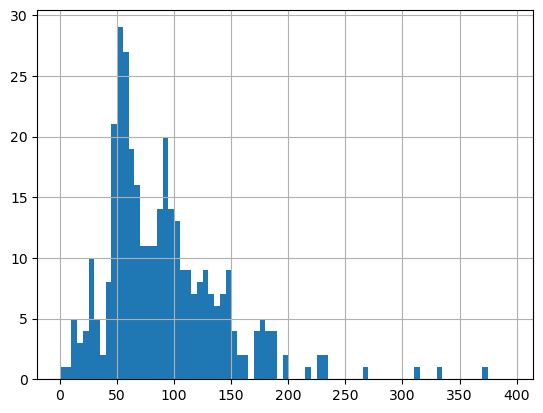

In [21]:
# It can be much more efficient to do things like check if elements in
# one sequence exist in another using pandas objects rather than the
# standard python library, so I flatten the lists of lists of entries
# into pandas series containing all the entries.
old_entries = pd.Series(
    [e for page in entries_by_page for e in page],
    dtype=pd.StringDtype()
)
new_entries = pd.Series(
    [e for page in new_entries_by_page for e in page],
    dtype=pd.StringDtype()
)

# strip nonprinting characters and replace all newlines in each entry
# with spaces
old_entries = old_entries.str.strip()
new_entries = new_entries.str.strip()
old_entries = old_entries.str.replace('\n', ' ')
new_entries = new_entries.str.replace('\n', ' ')

# Get new entries that don't exist in the old set
#new_entries = new_entries.loc[~new_entries.isin(old_entries)]
new_entries_not_in_old_entries = new_entries.loc[~new_entries.isin(old_entries)]

print(f'number of new entries (total): {len(new_entries)}')
print(f'number of old entries (total): {len(old_entries)}')

print(f'number of new entries not in old entries: {len(new_entries_not_in_old_entries)}')


# plot a histogram of lengths of the new entries
fig2 = new_entries_not_in_old_entries.map(len).hist(bins=range(0, 400, 5))

We can also print out some of the new entries to see how they look

In [26]:
for entry in new_entries_not_in_old_entries[:20]:
    print(entry)
    print("_______________")

Aberdeen : Old Deeside Road, Fraser (G. M.) 125, 6d. net . Dec. '21
_______________
ACHARYA Abhinava Gupta-Malinivijaya Varttikam. Ed. in Sanskrit with notes by Madhusudan Kaul. 8vo., pp. 138, 6s. 6d., 78. 6d. (Kashmir ser. of texts and studies) LUZAC; PROBSTHAIN, Mar. '22
_______________
Admiralty-Dockyard expense accounts, 1920-21
_______________
20. net H.M.S.O., Nov. '22
_______________
Admiralty-King's regulations and Admiralty instructions : amendments. 4d. net H.M.S.O., Dec. '21
_______________
Admiralty-King's regulations, etc. (Monthly.) ea. 4d. or gd.gnet. ..H.M.S.O., Jan., etc., '22
_______________
Æsthetics, System of, Jaques (G. H.) Vol. 1. I2s, Ed. net .Dec.'21
_______________
Aether, Definition of the, Loring (F. H.) IS. net. Nov. '22
_______________
Agriculture and Fisheries (Ministry of)-Intelli- gence Dept. : report, 1919–21.
_______________
5s, net. H.M.S.O., July '22
_______________
Agriculture, Indian : Call to India, &c., Jadhava (K.) 35. 6d. net Dec. '21
________

We can also look at another histogram of our overall results, with the new entries included.

<Axes: >

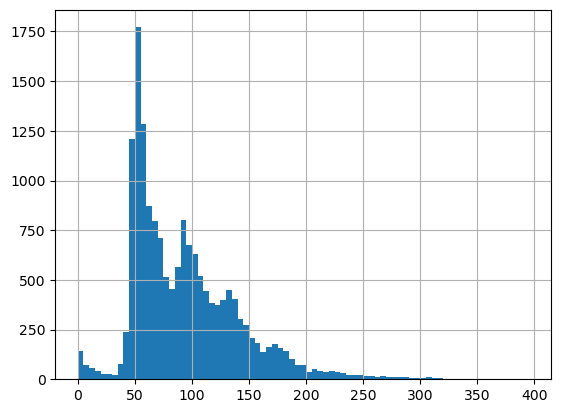

In [27]:
new_entries.map(len).hist(bins=range(0, 400, 5))

And if we want, we can look again at the longest entries in the list:

In [29]:
for entry in new_entries:
    if len(entry)>300:
        print(entry)
        print("__________")

Acts of Parliament-Local and private Acts passed in the with and 12th years of the reign of H.M. King George V. ; with index. 35. 6d. net ...H.M.S.O., 1922 Acts (Public General) —Table showing effect of the Acts passed in the with and 12th years of the reign of H.M. George V. IS, 6d. net. H.M.S.O., Apr. '22
__________
Acts of Parliament-Anglo-Persian Oil Company, 2d.; Audit (local authorities), 2d.; Bread (amend.). 2d.; British Empire Exhibition (amend.), 2d. ; Canals (charging powers), 2d.; Coroners (emergency provisions continuance), 2d. ; Consolidated Fund, No. 1—2, ea. 2d.; Diseases of animals, 2d.; E. India loans (railways, etc.), 2d. ; Finance, gd.; Gaming, 2d.; Govt. of N. Ireland (loan), 2d. ; Govt. of Soudan (loan), 2d.; Harbours, docks and piers (increase of charges), ad. ; Infanticide, Irish Free State (agreement), 3d. ; Juries, 3d.; Kenya divorces (validity), 2d.; Pawnbrokers, 2d. ; Sale of tea, 2d. ; Summer time, 2d.; Treaties of Washington, 3d. ; Unemployment insurance, 6

Finally, we can save our updated list of entries to a CSV.

In [32]:
entries_1922_updated = pd.DataFrame(new_entries)

In [34]:
entries_1922_updated.to_csv('entries_1922_updated.csv', index=False, header=False, encoding="utf-8")